In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass
from hmmlearn import hmm
from functions import *
from random import shuffle
from random import seed
from graphviz import Digraph
import pydot
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

### Loading the data

In [2]:
df = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized.txt')
df_scores = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_data_anonymized.txt')
df["student"] = df["student"].astype('category')
df_scores["student"] = df_scores["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()

def remodel_families(row):
    if row["Family"] == "Build" or row["Family"] == "Revise":  # or row["Family"] == "Extra":
        if row["Outcome"] != "None":
            return "ConstructWithFeedback"
        else:
            return "Construct"
    else:
        return row["Family"]
    
df['Family'] = df.apply (lambda row: remodel_families (row),axis=1)

In [3]:
# from pivottablejs import pivot_ui
# pivot_ui(df)

### Some parameters

In [4]:
ACTIONS_TO_REMOVE = ['I','O','S']
ITERS = 300
RAND_INT = 2
seed(RAND_INT)
CUTOFF = 0.01
events = [e for e in ["T","S","O","F","P","I","E","X","C",] if e not in ACTIONS_TO_REMOVE]
blues = ["#c7e9b4","#7fcdbb","#41b6c4","#2c7fb8","#253494"]
greys = ['#d9d9d9','#bdbdbd','#969696','#737373','#525252']

### Declaring a few functions

In [5]:
translater = {e:events.index(e) for e in events}
decoder = {events.index(e):e for e in events}
decoder_plus = {"T":"Test","S":"Start","O":"Organize","F":"C.w.Feedback","P":"Pause","I":"Interface","E":"Extra","X":"Reset","C":"Construct"}

def state_labeller(state,emission):
    indices = list(np.where(emission[state]>0.05)[0])
    label = " +\n".join([decoder_plus[decoder[i]] + ' (' + str(int(emission[state,i]*100)) + '%)' for i in indices])
    return label
    
def get_color(w,color_set):
    def get_cmap(colors):
        return [(float(i)/len(colors),c) for i,c in enumerate(colors)]
    color = None
    for p,c in get_cmap(color_set):
        if w >= p:
            color = c
    return color

def prepare_data(blocks):
    shuffled_blocks = blocks.values()
    shuffle(shuffled_blocks)
    X = np.array( np.array([np.concatenate([  [int(translater[event]) for event in block.split(' ')] for block in shuffled_blocks])]).T )
    lengths = [len(b.split(' ')) for b in blocks.values()]
    return X, lengths

def split_data(X, lengths, split):
    n_train = int(len(lengths)*split)
    n_test = len(lengths) - n_train
    lengths_train, lengths_test = lengths[0:n_test], lengths[n_test:]
    X_train, X_test = X[0:sum(lengths_train)], X[sum(lengths_train):]
    return X_train, X_test, lengths_train, lengths_test

def get_model(X,lengths,n_states, iters=ITERS, random_state=RAND_INT):
    '''Note that all integers in the range of observations must be present in the data!!'''
    converged = False
    tries = 0
    while converged == False:
        model = hmm.MultinomialHMM(n_components=n_states,
                            n_iter = iters,
                            random_state = random_state).fit(X,lengths)
        converged = model.monitor_.converged
        tries += 1
    print "Model with {0} hidden states converged after {1} tries, with {2} iterations".format(n_states, tries, model.monitor_.iter)
    return model

def draw_states_graph(model, cutoff = CUTOFF, label = True):
    states = Digraph('states')
    states.graph_attr.update(rankdir='LR')
    states.node_attr.update(shape='circle')
    for (i,j), p in np.ndenumerate(model.transmat_):
        if p >= cutoff:
            if label:
                states.edge(str(state_labeller(i,model.emissionprob_)),
                        str(state_labeller(j,model.emissionprob_)), 
                        color = get_color(p,blues), label = "{:.02f}".format(p), penwidth=str(5*p+2))
            else:
                states.edge(str(i), str(j), 
                    color = get_color(p,blues), label = "{:.02f}".format(p), penwidth=str(5*p+2))
#     if save:
#         figname = 'hmm_non_blocked.png'#N={0}_act={1}_{2}.png'.format(N,ACTIVITY,'low')
#         plt.savefig(figname)
    return states

def draw_hmm_graph(model, cutoff = CUTOFF, label = True, layout_circle=True):
    g = Digraph('G')
    if layout_circle:
        g.graph_attr.update(layout='circo')
    states = Digraph('states')
    states.node_attr.update(shape='circle',rank="max", fontsize='12')
    #Adding edge between hidden states
    for (i,j), p in np.ndenumerate(model.transmat_):
        if p >= cutoff:
            if label:
                states.edge(str(state_labeller(i,model.emissionprob_)),
                        str(state_labeller(j,model.emissionprob_)), 
                        color = get_color(p,blues), label = "{:.02f}".format(p), penwidth=str(5*p+2))
            else:
                states.edge(str(i), str(j), 
                        color = get_color(p,blues), label = "{:.02f}".format(p), penwidth=str(5*p+2))
    states.body.append('label = "states"')

    actions = Digraph('actions')
    actions.node_attr.update(shape='square')
    for (i,j), p in np.ndenumerate(model.emissionprob_):
        if p >= CUTOFF:
            if label:
                actions.edge(str(state_labeller(i,model.emissionprob_)),
                         str(decoder[j]), color = get_color(p,greys), 
                         label = "{:.02f}".format(p), penwidth=str(5*p+2))
            else:
                actions.edge(str(i), str(decoder[j]), color = get_color(p,greys), 
                         label = "{:.02f}".format(p), penwidth=str(5*p+2))
    actions.body.append('label = "actions"')
    actions.body.append('color=blue')

    g.subgraph(states);g.subgraph(actions)
    return g

### Modelling
#### Getting the data
 First, we get the student actions in blocks and keep only the actions we care about. We also build a translator and decoder to pass the actions as discreet integers instead of strings

In [6]:
ACTIVITY = 'a1'
blocks = get_non_blocks(df[df.Activity==ACTIVITY],get_students(),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)

We concatenate the student actions into one array and computer their lengths. Since the student sequences might be stored in a specific order, we shuffle them first.

In [7]:
blocks

{1075123: 'C C C C C C C C C C C F F F F P F F P F T T T T P T T T T T T T T T T T T T P T F C C C C F P T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T P T T F C C C C F T T T T T T T T T T T T T T T T T P T T T T T T T P T T T T T T T P T T T T T T X C C C C C C C C C C C C C C C F C C C C C C C C C C F T T T T T T T T T T T T T T F F T T T T T T T T T T T T T T T T T T T P T T P C C C C C C C C C C F P T T T T T T T T T T T T T T T T P T T T C F C F C T T T C T C C F C C C C C C C C C C F T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T P P T T T T T T T T T T T T T T T T T T T T T T T T T P T T T T T T T P X C C C C C C C C C C C C C C C C C C C C C C C C F T T T T T T T T T T T T T T T T T T T T T T T T T T P C C C C C C C C C F F F F C C C P T T T T T T T T T',
 3591123: 'C C C C C C C C C C C F P T T T T T T T T P T T T T T T T T T T T T T T T T T T T T T T T T T P T T T C C F C C C C C C F F C C C F T T T T T F T T T C C C C F 

In [8]:
X, lengths = prepare_data(blocks)

#### Formatting the data for cross validation
We split the data into a training and test set using a 60/40 % split

In [9]:
X_train, X_test, lengths_train, lengths_test = split_data(X, lengths, 0.6)

We produce the model with the train set using different number of hidden states

In [10]:
# scores = []
# models = []
# n_states = range(1,len(events)+3)
# print "Computing HMM model for 39 samples of observations"
# for n in n_states:
#     %time model = get_model(X_train, lengths_train, n)
#     scores.append(model.score(X_test, lengths = lengths_test))
#     models.append(model)

#### Now we can plot the scores

In [11]:
# bics = [-2*L + k*np.log(len(X_train)) for L,k in zip(scores, n_states)]
# plt.plot(n_states, bics,'-o')
# plt.title("BIC of models vs. number of hidden states in model")

### Analysis of model
Given that we want to trade off between the number of hidden states and the information gained, we pick the number of hidden states as 4 (which is where there is an elbow in the plot above). We store the transition and emition probabilities and visualize them. 

**Note**: We only draw edges with an emission or transition porbability greater than the CUTOFF variable declared above.

In [12]:
# N = 4
# draw_hmm_graph(models[N-1], label=False)

Unfortunately, seems like having 4 hidden states creates a pretty boring HMM: each states produces one of the main actions with 0.9 prob or more. So let's go back to 3 states and see what that gives us.

In [13]:
# N = 3
# draw_hmm_graph(models[N-1],label=False)

### Analysis of student groups
Now that we have it all figure it out, we can repeat the process with different groups of students and compare them!

In [14]:
ACTIVITY = 'a1'

blocks_scaff = get_non_blocks(df[df.Activity==ACTIVITY],get_students("scaffolding","scaff"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
blocks_not = get_non_blocks(df[df.Activity==ACTIVITY],get_students("scaffolding","not"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
X_scaff, lengths_scaff = prepare_data(blocks_scaff)
X_not, lengths_not = prepare_data(blocks_not)

In [26]:
N = 4
model_scaff = get_model(X_scaff, lengths_scaff, N)
model_not = get_model(X_not, lengths_not, N)

Model with 4 hidden states converged after 1 tries, with 160 iterations
Model with 4 hidden states converged after 1 tries, with 300 iterations


In [27]:
print model_scaff.score(X_scaff,lengths_scaff), model_not.score(X_not,lengths_not)

-11148.8396457 -11899.4859981


In [28]:
graph = draw_states_graph(model_scaff)

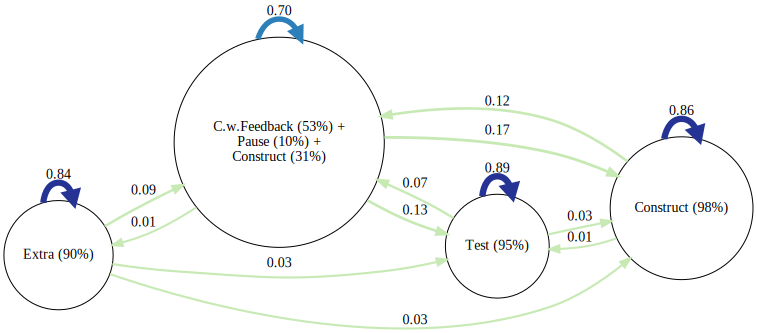

In [18]:
draw_states_graph(model_not)

Clearly, scaffolded students do switch from a state of Test + Pause to Construct with Feedback and later Construct. Not scaffolded students go from a Pause and Construct with Feedback state to Constructing state and occasionaly enter a Testing state.

#### Now let's see if the treatment differences transfered to activity 2

In [19]:
ACTIVITY = 'a2'

blocks_scaff = get_non_blocks(df[df.Activity==ACTIVITY],get_students("scaffolding","scaff"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
blocks_not = get_non_blocks(df[df.Activity==ACTIVITY],get_students("scaffolding","not"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
X_scaff, lengths_scaff = prepare_data(blocks_scaff)
X_not, lengths_not = prepare_data(blocks_not)

N = 4
model_scaff = get_model(X_scaff, lengths_scaff, N)
model_not = get_model(X_not, lengths_not, N)

print model_scaff.score(X_scaff,lengths_scaff), model_not.score(X_not,lengths_not)

Model with 4 hidden states converged after 1 tries, with 160 iterations
Model with 4 hidden states converged after 1 tries, with 300 iterations
-11148.8396457 -11899.4859981


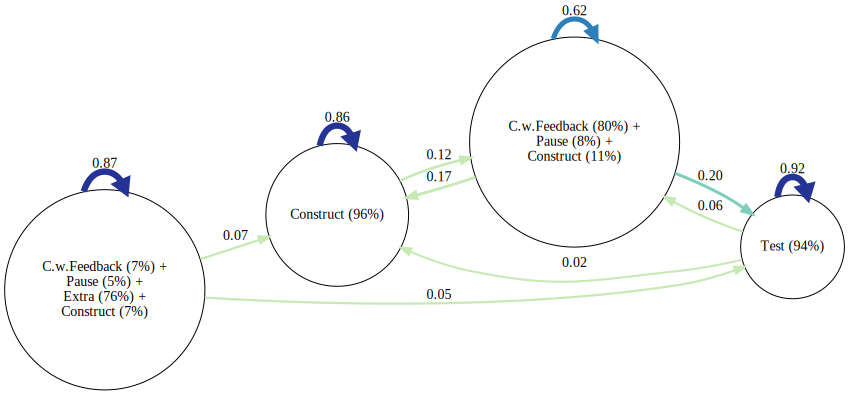

In [20]:
draw_states_graph(model_scaff)

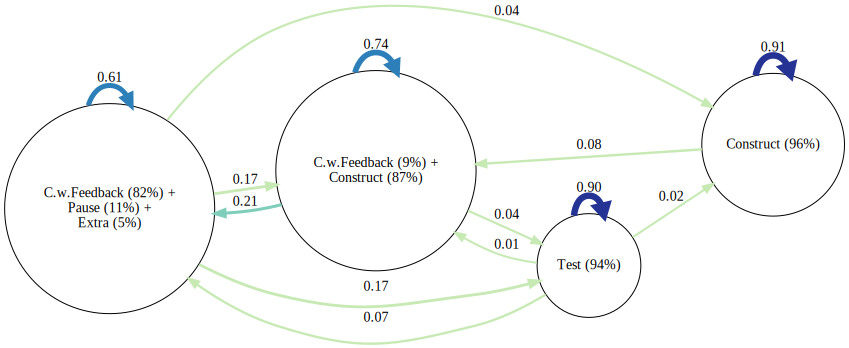

In [21]:
draw_states_graph(model_not)

### Let's compare students by learning

In [22]:
ACTIVITY = 'a2'

blocks_high = get_non_blocks(df[df.Activity==ACTIVITY],get_students("learning2","high"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
blocks_low = get_non_blocks(df[df.Activity==ACTIVITY],get_students("learning2","low"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
X_high, lengths_high = prepare_data(blocks_high)
X_low, lengths_low = prepare_data(blocks_low)

In [23]:
N = 4
model_high = get_model(X_high, lengths_high, N)
model_low = get_model(X_low, lengths_low, N)
print model_high.score(X_high,lengths_high), model_low.score(X_low,lengths_low)

Model with 4 hidden states converged after 1 tries, with 300 iterations
Model with 4 hidden states converged after 1 tries, with 181 iterations
-11054.049315 -12077.8474446


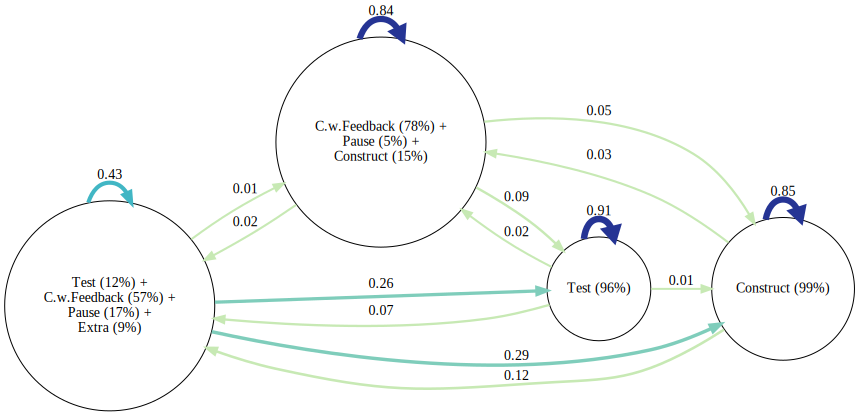

In [24]:
draw_states_graph(model_high)

In [25]:
draw_states_graph(model_low, save=True)

TypeError: draw_states_graph() got an unexpected keyword argument 'save'